In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.datasets import ImageFolder
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier 



In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



data_dir = '/kaggle/input/colorectal-cancer/Dataset 1/Colorectal Cancer '


classes = ['MUS', 'NORM', 'STR']
classes = ['MUS', 'NORM', 'STR']
class_counts = {class_name: 0 for class_name in classes}


for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    # Count the number of .tif files for each class
    class_counts[class_name] = len([filename for filename in os.listdir(class_path) if filename.endswith('.tif')])

print(class_counts)

images = []
labels = []


for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.tif'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            images.append(image)
            labels.append(class_name)


X = np.array(images)
y = np.array(labels)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




{'MUS': 2000, 'NORM': 2000, 'STR': 2000}


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/25, Train Loss: 1.1116, Train Accuracy: 0.3696, Validation Loss: 1.0661, Validation Accuracy: 0.4683
Epoch 2/25, Train Loss: 1.0450, Train Accuracy: 0.5104, Validation Loss: 1.0135, Validation Accuracy: 0.5633
Epoch 3/25, Train Loss: 0.9890, Train Accuracy: 0.5917, Validation Loss: 0.9577, Validation Accuracy: 0.6083
Epoch 4/25, Train Loss: 0.9214, Train Accuracy: 0.6685, Validation Loss: 0.8842, Validation Accuracy: 0.6783
Epoch 5/25, Train Loss: 0.8534, Train Accuracy: 0.6977, Validation Loss: 0.8263, Validation Accuracy: 0.7267
Epoch 6/25, Train Loss: 0.7948, Train Accuracy: 0.7371, Validation Loss: 0.7663, Validation Accuracy: 0.7483
Epoch 7/25, Train Loss: 0.7408, Train Accuracy: 0.7627, Validation Loss: 0.7211, Validation Accuracy: 0.7583
Epoch 8/25, Train Loss: 0.6914, Train Accuracy: 0.7756, Validation Loss: 0.6783, Validation Accuracy: 0.7717
Epoch 9/25, Train Loss: 0.6436, Train Accuracy: 0.7900, Validation Loss: 0.6428, Validation Accuracy: 0.7933
Epoch 10/25, Train 

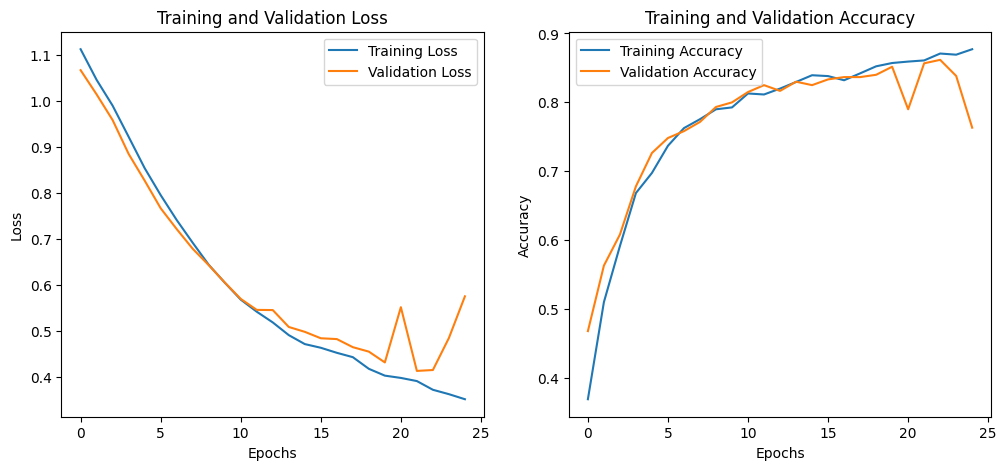

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


# Define hyperparameters
batch_size = 32  # Fixed batch size
learning_rate = 0.0001  # Fixed learning rate
epochs = 25

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),  # Ensure input is a PIL image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformations to your data
X_train_transformed = torch.stack([data_transform(x) for x in X_train])
X_val_transformed = torch.stack([data_transform(x) for x in X_val])
X_test_transformed = torch.stack([data_transform(x) for x in X_test])

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training, validation, and test sets
train_dataset = TensorDataset(X_train_transformed, y_train_tensor)
val_dataset = TensorDataset(X_val_transformed, y_val_tensor)
test_dataset = TensorDataset(X_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define ResNet-18 model and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)

# Training and validation loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

  

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()






Test Accuracy: 0.8100
Precision: 0.8541
Recall: 0.8031
F1 Score: 0.8111

Classification Report:

              precision    recall  f1-score   support

         MUS       0.69      0.97      0.80       219
        NORM       1.00      0.80      0.89       187
         STR       0.87      0.64      0.74       194

    accuracy                           0.81       600
   macro avg       0.85      0.80      0.81       600
weighted avg       0.85      0.81      0.81       600



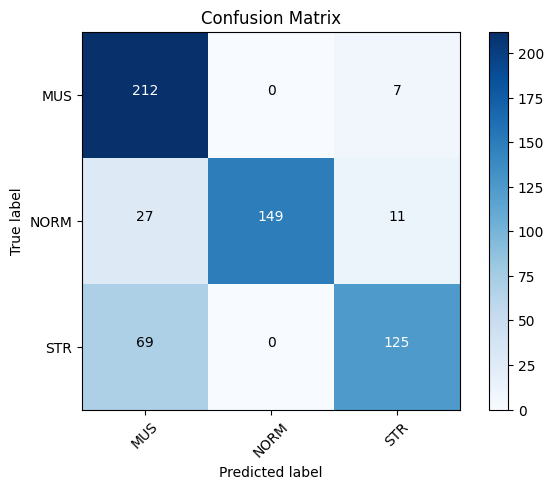

In [4]:
#test set evaluation for our model from scratch
model.eval()
test_loss = 0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.4f}')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [5]:
# Save the trained model
model_save_path = '/kaggle/working/model.pth'

# Save the model state
torch.save(model.state_dict(), model_save_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


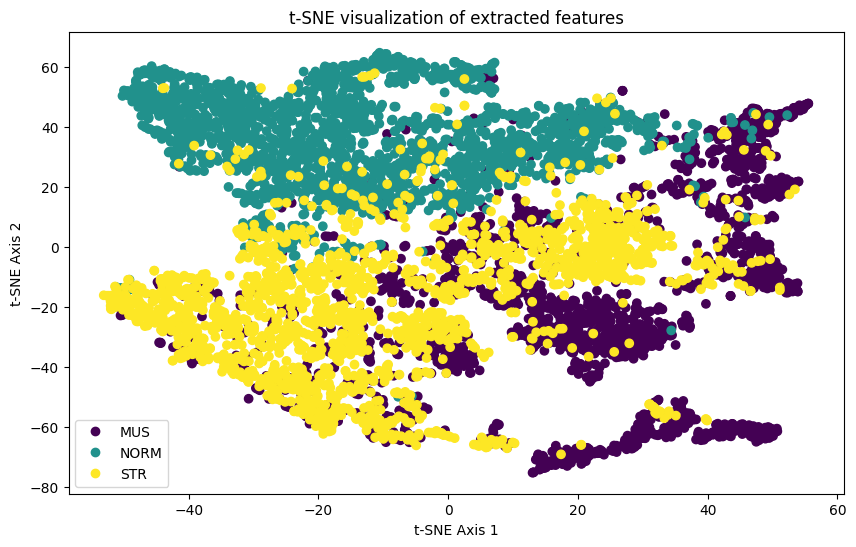

In [11]:
#TSNE plot on dataset 1 with the model from scratch
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

# Load and preprocess the dataset
data_dir = '/kaggle/input/colorectal-cancer/Dataset 1/Colorectal Cancer '
classes = ['MUS', 'NORM', 'STR']
images = []
labels = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.tif'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(image)
            labels.append(class_name)

X = np.array(images)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
])

# Apply transformations to the entire dataset
X_transformed = torch.stack([data_transform(x) for x in X])
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
dataset = TensorDataset(X_transformed, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load the pre-trained model
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model_path = '/kaggle/working/model.pth'  
model.load_state_dict(torch.load(model_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Modify the ResNet model for feature extraction
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        return x

# Instantiate the feature extractor
feature_extractor = ResNetFeatureExtractor(model).to(device)

# Feature Extraction
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, y in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.extend(output.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(features), np.array(labels)

# Extract features from the entire dataset
features, labels = extract_features(loader, feature_extractor)

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


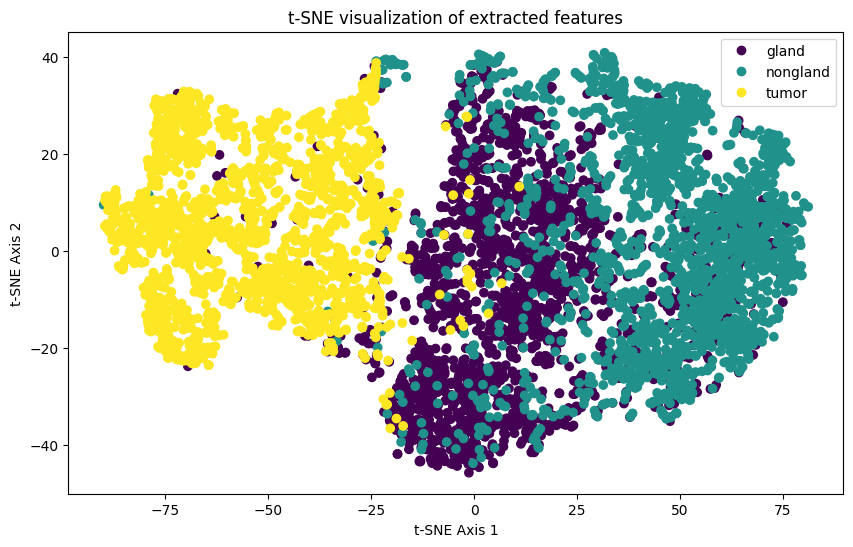

In [14]:
#Using the model from scratch to plot the tsne plot on the dataset 2
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

# Load and preprocess the dataset
data_dir = '/kaggle/input/prostate-cancer/Dataset 2/Prostate Cancer'
classes = ['gland', 'nongland', 'tumor']
images = []
labels = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(image)
            labels.append(class_name)

X = np.array(images)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformations to the entire dataset
X_transformed = torch.stack([data_transform(x) for x in X])
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
dataset = TensorDataset(X_transformed, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load the pre-trained model
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model_path = '/kaggle/working/model.pth' 
model.load_state_dict(torch.load(model_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Modify the ResNet model for feature extraction
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        return x

# Instantiate the feature extractor
feature_extractor = ResNetFeatureExtractor(model).to(device)

# Feature Extraction
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, y in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.extend(output.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(features), np.array(labels)

# Extract features from the entire dataset
features, labels = extract_features(loader, feature_extractor)

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()


Accuracy: 0.8916666666666667
Precision: 0.8929404368095835
Recall: 0.89358510932798
F1 Score: 0.8932501920172263

Classification Report:
               precision    recall  f1-score   support

       gland       0.85      0.85      0.85       437
    nongland       0.86      0.86      0.86       380
       tumor       0.96      0.97      0.97       383

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200



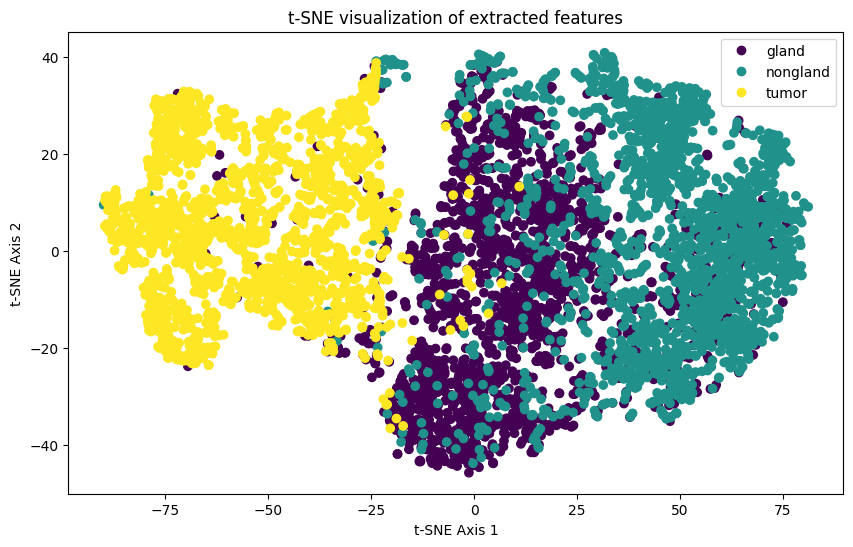

In [15]:
#Applying knn neighbours on the features extracted from dataset 2
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the kNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)

# Train the classifier
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred, target_names=classes)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

In [16]:
#Appling SVM on features extracted from dataset 2
# Extract features from the entire dataset
features, labels = extract_features(loader, feature_extractor)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Import the SVM classifier
from sklearn.svm import SVC

# Initialize the SVM Classifier
svm = SVC(kernel='linear')  # You can change the kernel as needed

# Train the classifier
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred, target_names=classes)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", report)

Accuracy: 0.9183333333333333
Precision: 0.9195825073372266
Recall: 0.920511120006851
F1 Score: 0.9197615204492995

Classification Report:
               precision    recall  f1-score   support

       gland       0.90      0.87      0.89       437
    nongland       0.87      0.92      0.89       380
       tumor       0.98      0.97      0.98       383

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


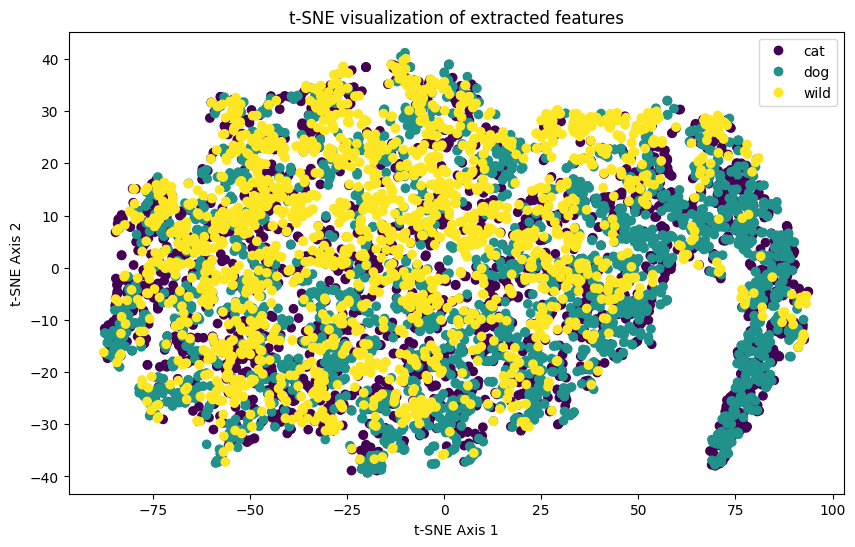

In [9]:
#TSNE plot on dataset 3 with the model from scratch
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

# Load and preprocess the dataset
data_dir = '/kaggle/input/animals/Dataset 3/Animal Faces'
classes = ['cat', 'dog', 'wild']
images = []
labels = []

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(class_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(image)
            labels.append(class_name)

X = np.array(images)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    
])

# Apply transformations to the entire dataset
X_transformed = torch.stack([data_transform(x) for x in X])
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Convert data to PyTorch tensors
dataset = TensorDataset(X_transformed, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load the pre-trained model
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model_path = '/kaggle/working/model.pth'  
model.load_state_dict(torch.load(model_path))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Modify the ResNet model for feature extraction
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        return x

# Instantiate the feature extractor
feature_extractor = ResNetFeatureExtractor(model).to(device)

# Feature Extraction
def extract_features(loader, model):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, y in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.extend(output.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return np.array(features), np.array(labels)

# Extract features from the entire dataset
features, labels = extract_features(loader, feature_extractor)

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()
